**Import libraries**

In [1]:
import torch
import torchvision

from torch import nn

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

**Calculating patch embedding input and output shapes**

In [2]:
IMAGE_PATH = "/image.jpg"
HEIGHT = 224 
WIDTH = 224
COLOR_CHANNELS = 3
PATCH_SIZE = 16
NUM_PATCHES = WIDTH / PATCH_SIZE 

number_of_patches = int((HEIGHT * WIDTH) / PATCH_SIZE**2)

embedding_layer_input_shape = (HEIGHT, WIDTH, COLOR_CHANNELS)
embedding_layer_output_shape = (number_of_patches, PATCH_SIZE**2 * COLOR_CHANNELS)

print(f"Number of patches --> {number_of_patches}\n")
print(f"Input shape --> {embedding_layer_input_shape}")
print(f"Output shape --> {embedding_layer_output_shape}")

Number of patches --> 196

Input shape --> (224, 224, 3)
Output shape --> (196, 768)


**Let's check how a patchified image will look**

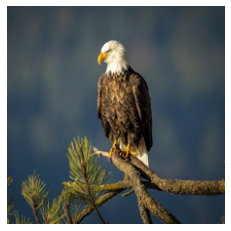

In [3]:
image = Image.open(IMAGE_PATH).resize((WIDTH,HEIGHT))

plt.imshow(image)
plt.axis(False);

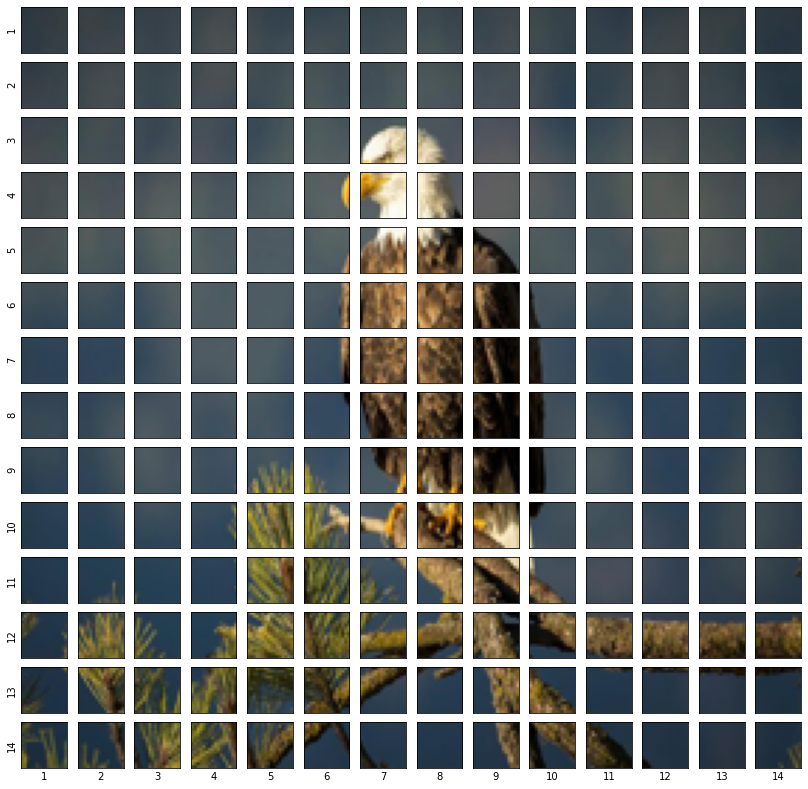

In [4]:
image = np.array(image)

fig, ax = plt.subplots(nrows=int(HEIGHT / PATCH_SIZE),
                       ncols=int(WIDTH / PATCH_SIZE), 
                       figsize=(NUM_PATCHES, NUM_PATCHES),
                       sharex=True,
                       sharey=True)

for i, patch_height in enumerate(range(0, HEIGHT, PATCH_SIZE)):
  for j, patch_width in enumerate(range(0, WIDTH, PATCH_SIZE)):
        
    ax[i, j].imshow(image[patch_height:patch_height+PATCH_SIZE,
                          patch_width:patch_width+PATCH_SIZE,
                          :])
        
    ax[i, j].set_ylabel(i+1)
    ax[i, j].set_xlabel(j+1) 
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].label_outer()

plt.show()

**Transform the image into tensor**

In [5]:
image = Image.open(IMAGE_PATH)

manual_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((WIDTH, HEIGHT)),
                                                    torchvision.transforms.ToTensor()])

image = manual_transforms(image)

**Creating the image patches**

In [6]:
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=PATCH_SIZE,
                   stride=PATCH_SIZE)

flatten = nn.Flatten(start_dim=2,
                     end_dim=3)

image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv_flattened = flatten(image_out_of_conv)

image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)

print(f"Image --> {image.shape}")
print(f"Image feature map --> {image_out_of_conv.shape}")
print(f"Flattened image feature --> {image_out_of_conv_flattened.shape}")
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Image --> torch.Size([3, 224, 224])
Image feature map --> torch.Size([1, 768, 14, 14])
Flattened image feature --> torch.Size([1, 768, 196])
Patch embedding sequence shape: torch.Size([1, 196, 768])


**Patch embedding module**

In [7]:
class PatchEmbedding(nn.Module):
    
    def __init__(self, 
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        # Layer
        self.conv2d = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size)

        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):

        x_patched = self.conv2d(x)
        x_flattened = self.flatten(x_patched) 
        return x_flattened.permute(0, 2, 1)

In [8]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

patch_embedded_image = patchify(image.unsqueeze(0))

print(f"Input image shape: {image.unsqueeze(0).shape}")
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


**Creating the class token embedding**

In [9]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension))

patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1)

print(f"{patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


**Creating the position embedding**

In [10]:
number_of_patches = int((HEIGHT * WIDTH) / PATCH_SIZE**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension))

**Multi-Head Attention (MSA)**

In [11]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim=768,
                 num_heads=12,
                 attn_dropout=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, attn_output_weights = self.multihead_attn(query=x,
                                                               key=x,
                                                               value=x,
                                                               need_weights=False)
        return attn_output

multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12)

**Multilayer Perceptron (MLP)**

In [12]:
class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim=768,
                 mlp_size=3072,
                 dropout=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

**Create the Transformer Encoder**

In [13]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                 embedding_dim=768,
                 num_heads=12,
                 mlp_size=3072,
                 mlp_dropout=0.1,
                 attn_dropout=0): 
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x 
        x = self.mlp_block(x) + x 
        return x

transformer_encoder_block = TransformerEncoderBlock()

**Create ViT**

In [14]:
class ViT(nn.Module):

    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=2):
        super().__init__()
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim))
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes))
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])

        return x

vit = ViT(num_classes=1000) 

**ViT Summary**

In [15]:
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

summary(model=vit, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv2d)                                       [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]